# Testing FFNN on classification problems

In [1]:
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
import itertools
import autograd.numpy as np
import pandas as pd
from tqdm import tqdm

from activation_functions import *
from cost_functions import *
from FFNN import *

# Setting the random seed
np.random.seed(42)


In [2]:

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
# Extract data (features) and target (labels)
X = mnist.data[:2500]
y = mnist.target[:2500]

# Scaling the mnist pixel values from 0-255 to 0-1
X = X / 255.0

print(X.shape)
print(y.shape)

(2500, 784)
(2500,)


In [3]:
# Splitting the data into testing, training and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

# One-hot encoding
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)
y_val = to_one_hot(y_val)

# Testing parameter combinations with grid search

In [4]:
# Splitting the data into testing an training sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

# One-hot encoding
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)
y_val = to_one_hot(y_val)

In [5]:
# Define parameters
layer_sizes = [25, 250, 1000]
num_hidden_layers = [0, 1, 2, 3]
etas = np.logspace(0, -2, num=3)
activation_functions = [sigmoid, ReLU, leaky_ReLU]
epochs = [100]
optimizers = [train_network_SRMSprop, train_network_stocastic_ADAM, train_network_stocastic_momentum, train_network_momentum]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]

In [6]:

total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results1 = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # If no hidden layers
    if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
    else:
        # Hidden layers + output layer
        layer_output_sizes = [num_nodes] * num_layers + [10]
        activation_funcs = [act_func] * num_layers + [softmax]

    # Create and train network
    NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

    optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

    train_pred = NN.predict(X_train)
    val_pred = NN.predict(X_val)
    test_pred = NN.predict(X_test)
    
    train_accuracy = accuracy(train_pred, y_train)
    val_accuracy = accuracy(val_pred, y_val)
    test_accuracy = accuracy(test_pred, y_test)

    # Store results
    results1.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_accuracy,
        'val_acc': val_accuracy,
        'test_acc': test_accuracy
    })

# Evaluate results
df_results1 = pd.DataFrame(results1)

# Save results to file
df_results1.to_csv("Mnist2500_results_rough.csv", index=False)

  0%|          | 0/432 [00:00<?, ?it/s]c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: invalid value encountered in divide
  defvjp(anp.log, lambda ans, x: lambda g: g / x)
  0%|          | 2/432 [00:02<10:17,  1.44s/it]c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:163: RuntimeWarning: divide by zero encountered in divide
  def

In [7]:
# Load the results from CSV
df_results1 = pd.read_csv("Mnist2500_results_rough.csv")

# Get top 25 configurations
top_50 = df_results1.nlargest(50, 'val_acc').copy()
top_50

,n_hidden,layer_size,eta,activation,n_epochs,optimizer,train_acc,val_acc,test_acc
277,2,250,0.01,sigmoid,100,train_network_stocastic_ADAM,0.990667,0.928,0.900
168,1,250,0.01,sigmoid,100,train_network_SRMSprop,0.999333,0.912,0.906
205,1,1000,0.01,sigmoid,100,train_network_stocastic_ADAM,0.990667,0.910,0.894
312,2,1000,0.01,sigmoid,100,train_network_SRMSprop,0.971333,0.910,0.866
204,1,1000,0.01,sigmoid,100,train_network_SRMSprop,0.992000,0.900,0.888
384,3,250,0.01,sigmoid,100,train_network_SRMSprop,0.989333,0.900,0.878
206,1,1000,0.01,sigmoid,100,train_network_stocastic_momentum,0.999333,0.898,0.876
170,1,250,0.01,sigmoid,100,train_network_stocastic_momentum,0.998000,0.894,0.882
276,2,250,0.01,sigmoid,100,train_network_SRMSprop,0.992667,0.886,0.902
132,1,25,0.01,sigmoid,100,train_network_SRMSprop,1.000000,0.882,0.850


In [8]:
print(top_50['n_hidden'].value_counts())
print(top_50['layer_size'].value_counts())
print(top_50['eta'].value_counts())
print(top_50['activation'].value_counts())
print(top_50['optimizer'].value_counts())

n_hidden
0    22
1    12
2    10
3     6
Name: count, dtype: int64
layer_size
25      20
250     16
1000    14
Name: count, dtype: int64
eta
0.01    41
0.10     9
Name: count, dtype: int64
activation
sigmoid       33
ReLU          11
leaky_ReLU     6
Name: count, dtype: int64
optimizer
train_network_SRMSprop              21
train_network_stocastic_ADAM        16
train_network_stocastic_momentum    13
Name: count, dtype: int64


In [9]:
# Define parameters
layer_sizes = [25, 100, 250, 500, 750, 1000]
num_hidden_layers = [0, 1, 2, 3, 4]
etas = [0.01]
activation_functions = [sigmoid]
epochs = [100]
optimizers = [train_network_SRMSprop]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]
n_runs = 10  # Number of runs per configuration

In [10]:
total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results2 = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # Arrays to store results from multiple runs
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    
    # Run the same configuration n_runs times
    for run in range(n_runs):
        # If no hidden layers
        if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [num_nodes] * num_layers + [10]
            activation_funcs = [act_func] * num_layers + [softmax]

        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

        optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

        train_pred = NN.predict(X_train)
        val_pred = NN.predict(X_val)
        test_pred = NN.predict(X_test)
        
        train_accuracies.append(accuracy(train_pred, y_train))
        val_accuracies.append(accuracy(val_pred, y_val))
        test_accuracies.append(accuracy(test_pred, y_test))
    
    # Compute averages and standard deviations
    train_acc_mean = np.mean(train_accuracies)
    val_acc_mean = np.mean(val_accuracies)
    test_acc_mean = np.mean(test_accuracies)
    
    train_acc_std = np.std(train_accuracies)
    val_acc_std = np.std(val_accuracies)
    test_acc_std = np.std(test_accuracies)

    # Store results
    results2.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_acc_mean,
        'val_acc': val_acc_mean,
        'test_acc': test_acc_mean,
        'train_acc_std': train_acc_std,
        'val_acc_std': val_acc_std,
        'test_acc_std': test_acc_std
    })

# Evaluate results
df_results2 = pd.DataFrame(results2)

# Save results to file
df_results2.to_csv("Mnist2500_results_depth.csv", index=False)

100%|██████████| 30/30 [3:35:40<00:00, 431.35s/it]  


In [11]:
# Get top 10 configurations
top_10 = df_results2.nlargest(10, 'val_acc').copy()
top_10


,n_hidden,layer_size,eta,activation,n_epochs,optimizer,train_acc,val_acc,test_acc,train_acc_std,val_acc_std,test_acc_std
11,1,1000,0.01,sigmoid,100,train_network_SRMSprop,0.993733,0.9168,0.9080,0.003428,0.010889,0.009960
10,1,750,0.01,sigmoid,100,train_network_SRMSprop,0.996133,0.9112,0.9002,0.001485,0.005810,0.008875
9,1,500,0.01,sigmoid,100,train_network_SRMSprop,0.995467,0.9096,0.8938,0.001950,0.008237,0.012758
14,2,250,0.01,sigmoid,100,train_network_SRMSprop,0.990133,0.9048,0.8892,0.002680,0.012303,0.013151
13,2,100,0.01,sigmoid,100,train_network_SRMSprop,0.997200,0.9030,0.8894,0.000833,0.006588,0.006873
7,1,100,0.01,sigmoid,100,train_network_SRMSprop,0.998667,0.9018,0.8844,0.001333,0.006353,0.004454
8,1,250,0.01,sigmoid,100,train_network_SRMSprop,0.997133,0.9006,0.8882,0.001933,0.017066,0.013280
20,3,250,0.01,sigmoid,100,train_network_SRMSprop,0.987600,0.9004,0.8832,0.007150,0.015253,0.017093
19,3,100,0.01,sigmoid,100,train_network_SRMSprop,0.996200,0.8996,0.8884,0.002405,0.012986,0.006681
25,4,100,0.01,sigmoid,100,train_network_SRMSprop,0.993933,0.8932,0.8858,0.004147,0.011600,0.009009


## Network architecture heatmap

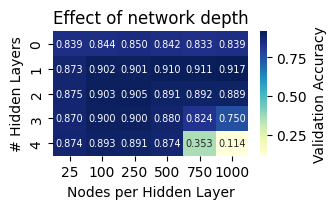

In [12]:
# Load the results from CSV
df_results = pd.read_csv("Mnist2500_results_depth.csv")

# Get unique values for the axes (switched)
num_hidden_layers = sorted(df_results['n_hidden'].unique())
layer_sizes = sorted(df_results['layer_size'].unique())

# Create 2D array for heatmap (dimensions switched)
results = np.zeros((len(num_hidden_layers), len(layer_sizes)))

# Fill the results array with validation accuracy (indices switched)
for i, num_layers in enumerate(num_hidden_layers):
    for j, layer_size in enumerate(layer_sizes):
        # Filter for this specific combination
        mask = (df_results['n_hidden'] == num_layers) & (df_results['layer_size'] == layer_size)
        
        if mask.any():
            # If multiple results exist for this combination, take the best validation accuracy
            results[i, j] = df_results[mask]['val_acc'].max()
        else:
            results[i, j] = np.nan

# Create heatmap with new formatting (labels switched)
fig, ax = plt.subplots(figsize=(3.375, 2.2))  # width x height in inches
sns.heatmap(results, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=layer_sizes,
            yticklabels=num_hidden_layers,
            cbar_kws={'label': 'Validation Accuracy'},
            annot_kws={'size': 7}, ax=ax)

ax.set_xlabel('Nodes per Hidden Layer')
ax.set_ylabel('# Hidden Layers')
ax.set_title('Effect of network depth', pad=6)
plt.tight_layout()
plt.show()

## Activation function test

In [15]:
# Define parameters
layer_sizes = [1000]
num_hidden_layers = [1]
etas = [0.01]
activation_functions = [sigmoid, ReLU, leaky_ReLU]
epochs = [100]
optimizers = [train_network_SRMSprop]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]
n_runs = 10  # Number of runs per configuration

In [ ]:
total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results3 = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # Arrays to store results from multiple runs
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    
    # Run the same configuration n_runs times
    for run in range(n_runs):
        # If no hidden layers
        if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [num_nodes] * num_layers + [10]
            activation_funcs = [act_func] * num_layers + [softmax]

        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

        optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

        train_pred = NN.predict(X_train)
        val_pred = NN.predict(X_val)
        test_pred = NN.predict(X_test)
        
        train_accuracies.append(accuracy(train_pred, y_train))
        val_accuracies.append(accuracy(val_pred, y_val))
        test_accuracies.append(accuracy(test_pred, y_test))
    
    # Compute averages and standard deviations
    train_acc_mean = np.mean(train_accuracies)
    val_acc_mean = np.mean(val_accuracies)
    test_acc_mean = np.mean(test_accuracies)
    
    train_acc_std = np.std(train_accuracies)
    val_acc_std = np.std(val_accuracies)
    test_acc_std = np.std(test_accuracies)

    # Store results
    results3.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_acc_mean,
        'val_acc': val_acc_mean,
        'test_acc': test_acc_mean,
        'train_acc_std': train_acc_std,
        'val_acc_std': val_acc_std,
        'test_acc_std': test_acc_std
    })

# Evaluate results
df_results3 = pd.DataFrame(results3)

# Save results to file
df_results3.to_csv("Mnist2500_results_activ.csv", index=False)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Get top 10 configurations
top_10 = df_results2.nlargest(3, 'val_acc').copy()
top_10


## Testing cost optimizers

In [ ]:
# Define parameters
layer_sizes = [1000]
num_hidden_layers = [1]
etas = [0.01]
activation_functions = [sigmoid]
epochs = [100]
optimizers = [train_network_SRMSprop, train_network_stocastic_ADAM, train_network_stocastic_momentum, train_network_momentum]
cost_functions = [cross_entropy]

network_input_size = X_train.shape[1]
n_runs = 10  # Number of runs per configuration

In [ ]:
total_combinations = len(list(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers)))

# Store results
results4 = []

for _, (num_layers, num_nodes, eta, act_func, num_epochs, optimizer) in enumerate(tqdm(itertools.product(num_hidden_layers, layer_sizes, etas, activation_functions, epochs, optimizers), total=total_combinations)):

    # Arrays to store results from multiple runs
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    
    # Run the same configuration n_runs times
    for run in range(n_runs):
        # If no hidden layers
        if num_layers == 0:
            layer_output_sizes = [10]
            activation_funcs = [softmax]
        else:
            # Hidden layers + output layer
            layer_output_sizes = [num_nodes] * num_layers + [10]
            activation_funcs = [act_func] * num_layers + [softmax]

        # Create and train network
        NN = NeuralNetwork(network_input_size, layer_output_sizes, activation_funcs, cross_entropy)

        optimizer(NN, X_train, y_train, eta=eta, epochs=num_epochs)

        train_pred = NN.predict(X_train)
        val_pred = NN.predict(X_val)
        test_pred = NN.predict(X_test)
        
        train_accuracies.append(accuracy(train_pred, y_train))
        val_accuracies.append(accuracy(val_pred, y_val))
        test_accuracies.append(accuracy(test_pred, y_test))
    
    # Compute averages and standard deviations
    train_acc_mean = np.mean(train_accuracies)
    val_acc_mean = np.mean(val_accuracies)
    test_acc_mean = np.mean(test_accuracies)
    
    train_acc_std = np.std(train_accuracies)
    val_acc_std = np.std(val_accuracies)
    test_acc_std = np.std(test_accuracies)

    # Store results
    results4.append({
        'n_hidden': num_layers,
        'layer_size': num_nodes,
        'eta': eta,
        'activation': act_func.__name__,
        'n_epochs': num_epochs,
        'optimizer': optimizer.__name__,
        'train_acc': train_acc_mean,
        'val_acc': val_acc_mean,
        'test_acc': test_acc_mean,
        'train_acc_std': train_acc_std,
        'val_acc_std': val_acc_std,
        'test_acc_std': test_acc_std
    })

# Evaluate results
df_results3 = pd.DataFrame(results4)

# Save results to file
df_results3.to_csv("Mnist2500_results_optim.csv", index=False)